In [2]:
!nvidia-smi
import os

Sun Oct 22 16:17:11 2023       
+---------------------------------------------------------------------------------------+
| NVIDIA-SMI 536.67                 Driver Version: 536.67       CUDA Version: 12.2     |
|-----------------------------------------+----------------------+----------------------+
| GPU  Name                     TCC/WDDM  | Bus-Id        Disp.A | Volatile Uncorr. ECC |
| Fan  Temp   Perf          Pwr:Usage/Cap |         Memory-Usage | GPU-Util  Compute M. |
|                                         |                      |               MIG M. |
|=========================================+======================+======================|
|   0  NVIDIA GeForce GTX 1050      WDDM  | 00000000:01:00.0 Off |                  N/A |
| N/A   44C    P8              N/A / ERR! |      0MiB /  4096MiB |      0%      Default |
|                                         |                      |                  N/A |
+-----------------------------------------+----------------------+--

In [7]:
#!pip install pyyaml==5.1

import torch,os
TORCH_VERSION = ".".join(torch.__version__.split(".")[:2])
CUDA_VERSION = torch.__version__.split("+")[-1]
print("torch: ", TORCH_VERSION, "; cuda: ", CUDA_VERSION)
# Install detectron2 that matches the above pytorch version
# See https://detectron2.readthedocs.io/tutorials/install.html for instructions
#!pip install detectron2 -f https://dl.fbaipublicfiles.com/detectron2/wheels/$CUDA_VERSION/torch$TORCH_VERSION/index.html
# If there is not yet a detectron2 release that matches the given torch + CUDA version, you need to install a different pytorch.
# exit(0)  # After installation, you may need to "restart runtime" in Colab. This line can also restart runtime


torch:  2.2 ; cuda:  2.2.0.dev20231021
Looking in links: https://dl.fbaipublicfiles.com/detectron2/wheels/2.2.0.dev20231021/torch2.2/index.html


In [9]:
# Some basic setup:
# Setup detectron2 logger
import detectron2
from detectron2.utils.logger import setup_logger
setup_logger()

# import some common libraries
import numpy as np
import os, json, cv2, random


# import some common detectron2 utilities
from detectron2 import model_zoo
from detectron2.engine import DefaultPredictor
from detectron2.config import get_cfg
from detectron2.utils.visualizer import Visualizer
from detectron2.data import MetadataCatalog, DatasetCatalog

In [10]:
from detectron2.data.datasets import register_coco_instances
register_coco_instances("sample", {}, "./data/trainval.json", "./data/images")

In [11]:
sample_metadata = MetadataCatalog.get("sample")
dataset_dicts = DatasetCatalog.get("sample")

WARNING [10/22 16:29:57 d2.data.datasets.coco]: 
Category ids in annotations are not in [1, #categories]! We'll apply a mapping for you.

[10/22 16:29:57 d2.data.datasets.coco]: Loaded 51 images in COCO format from ./data/trainval.json


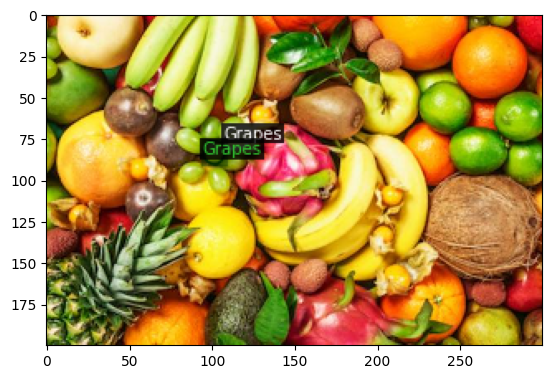

In [30]:
import random
import matplotlib.pyplot as plt
for d in random.sample(dataset_dicts, 4):
    img = cv2.imread(d["file_name"])
    visualizer = Visualizer(img[:, :, ::-1], metadata=sample_metadata, scale=0.5)
    vis = visualizer.draw_dataset_dict(d)
    plt.imshow(vis.get_image()[..., ::-1][..., ::-1])

In [31]:
from detectron2.engine import DefaultTrainer

cfg = get_cfg()
cfg.merge_from_file(model_zoo.get_config_file("COCO-InstanceSegmentation/mask_rcnn_R_50_FPN_3x.yaml"))
cfg.DATASETS.TRAIN = ("sample",)
cfg.DATASETS.TEST = ()
cfg.DATALOADER.NUM_WORKERS = 2
cfg.MODEL.WEIGHTS = model_zoo.get_checkpoint_url("COCO-InstanceSegmentation/mask_rcnn_R_50_FPN_3x.yaml")  # Let training initialize from model zoo
cfg.SOLVER.IMS_PER_BATCH = 2
cfg.SOLVER.BASE_LR = 0.0025  # pick a good LR
cfg.SOLVER.MAX_ITER = 500    # 300 iterations seems good enough for this toy dataset; you will need to train longer for a practical dataset
cfg.MODEL.ROI_HEADS.BATCH_SIZE_PER_IMAGE = 128   # faster, and good enough for this toy dataset (default: 512)
cfg.MODEL.ROI_HEADS.NUM_CLASSES = 14  # (see https://detectron2.readthedocs.io/tutorials/datasets.html#update-the-config-for-new-datasets)
# NOTE: this config means the number of classes, but a few popular unofficial tutorials incorrect uses num_classes+1 here.

os.makedirs(cfg.OUTPUT_DIR, exist_ok=True)
trainer = DefaultTrainer(cfg) 
trainer.resume_or_load(resume=False)
trainer.train()

[10/22 16:49:54 d2.engine.defaults]: Model:
GeneralizedRCNN(
  (backbone): FPN(
    (fpn_lateral2): Conv2d(256, 256, kernel_size=(1, 1), stride=(1, 1))
    (fpn_output2): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (fpn_lateral3): Conv2d(512, 256, kernel_size=(1, 1), stride=(1, 1))
    (fpn_output3): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (fpn_lateral4): Conv2d(1024, 256, kernel_size=(1, 1), stride=(1, 1))
    (fpn_output4): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (fpn_lateral5): Conv2d(2048, 256, kernel_size=(1, 1), stride=(1, 1))
    (fpn_output5): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (top_block): LastLevelMaxPool()
    (bottom_up): ResNet(
      (stem): BasicStem(
        (conv1): Conv2d(
          3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False
          (norm): FrozenBatchNorm2d(num_features=64, eps=1e-05)
        )
      )
      (res

Skip loading parameter 'roi_heads.box_predictor.cls_score.weight' to the model due to incompatible shapes: (81, 1024) in the checkpoint but (15, 1024) in the model! You might want to double check if this is expected.
Skip loading parameter 'roi_heads.box_predictor.cls_score.bias' to the model due to incompatible shapes: (81,) in the checkpoint but (15,) in the model! You might want to double check if this is expected.
Skip loading parameter 'roi_heads.box_predictor.bbox_pred.weight' to the model due to incompatible shapes: (320, 1024) in the checkpoint but (56, 1024) in the model! You might want to double check if this is expected.
Skip loading parameter 'roi_heads.box_predictor.bbox_pred.bias' to the model due to incompatible shapes: (320,) in the checkpoint but (56,) in the model! You might want to double check if this is expected.
Skip loading parameter 'roi_heads.mask_head.predictor.weight' to the model due to incompatible shapes: (80, 256, 1, 1) in the checkpoint but (14, 256, 1, 

[10/22 16:50:00 d2.engine.train_loop]: Starting training from iteration 0
[10/22 16:51:03 d2.utils.events]:  eta: 0:11:01  iter: 19  total_loss: 3.611  loss_cls: 2.463  loss_box_reg: 0.5795  loss_mask: 0.6901  loss_rpn_cls: 0.02327  loss_rpn_loc: 0.008151    time: 1.3659  last_time: 1.3656  data_time: 1.6816  last_data_time: 0.0027   lr: 9.7405e-05  max_mem: 2789M
[10/22 16:51:31 d2.utils.events]:  eta: 0:10:45  iter: 39  total_loss: 2.519  loss_cls: 1.144  loss_box_reg: 0.65  loss_mask: 0.6541  loss_rpn_cls: 0.02241  loss_rpn_loc: 0.01194    time: 1.3788  last_time: 1.4708  data_time: 0.0027  last_data_time: 0.0020   lr: 0.00019731  max_mem: 2841M
[10/22 16:52:00 d2.utils.events]:  eta: 0:10:31  iter: 59  total_loss: 2.086  loss_cls: 0.7658  loss_box_reg: 0.6858  loss_mask: 0.5996  loss_rpn_cls: 0.01741  loss_rpn_loc: 0.008563    time: 1.4091  last_time: 1.4523  data_time: 0.0043  last_data_time: 0.0024   lr: 0.0002972  max_mem: 2843M
[10/22 16:52:29 d2.utils.events]:  eta: 0:09:56  i

In [32]:
cfg.MODEL.WEIGHTS = os.path.join(cfg.OUTPUT_DIR, "model_final.pth")
cfg.MODEL.ROI_HEADS.SCORE_THRESH_TEST = 0.5   # set the testing threshold for this model
cfg.DATASETS.TEST = ("sample", )
predictor = DefaultPredictor(cfg)

[10/22 17:03:39 d2.checkpoint.detection_checkpoint]: [DetectionCheckpointer] Loading from ./output\model_final.pth ...


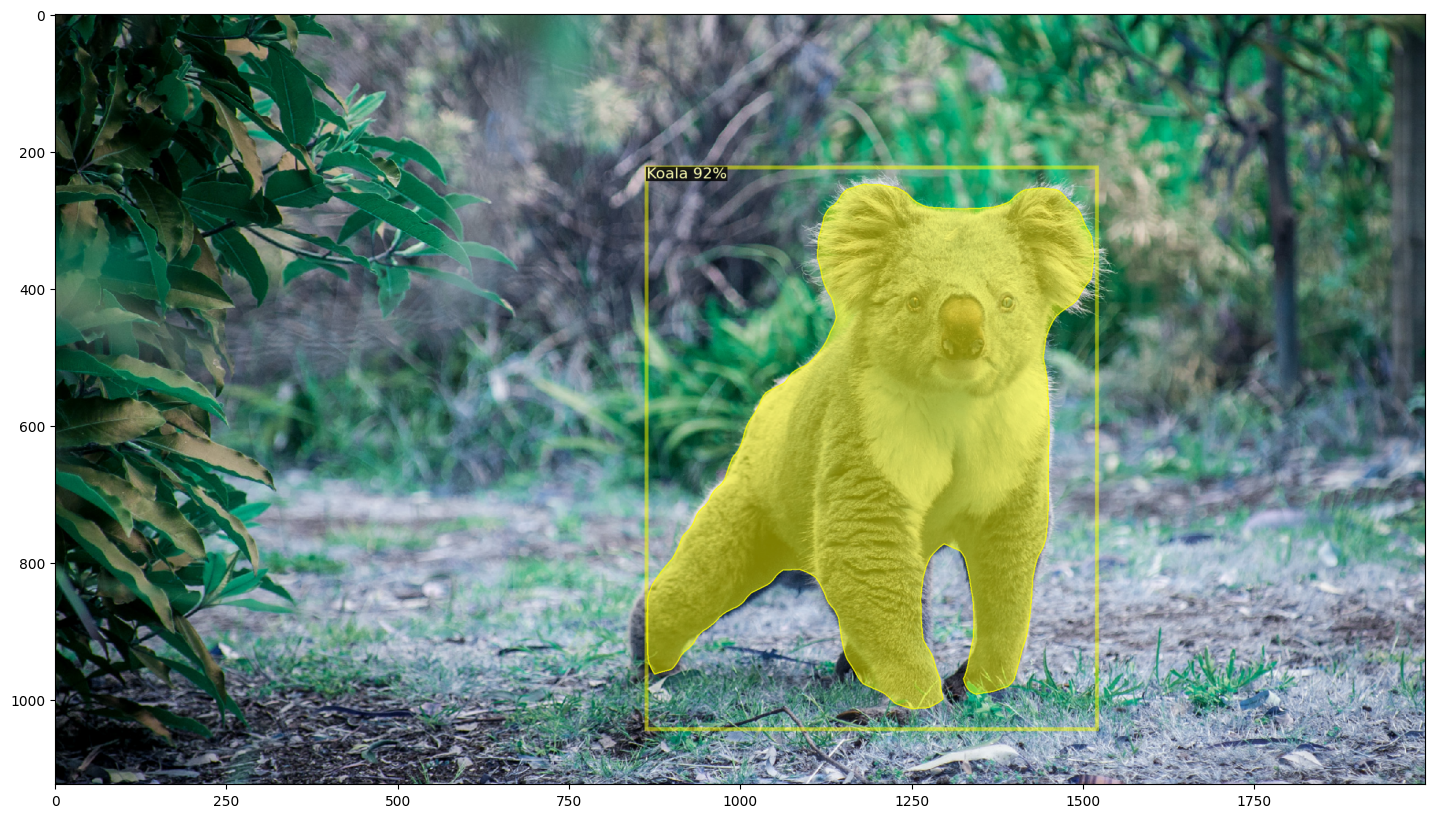

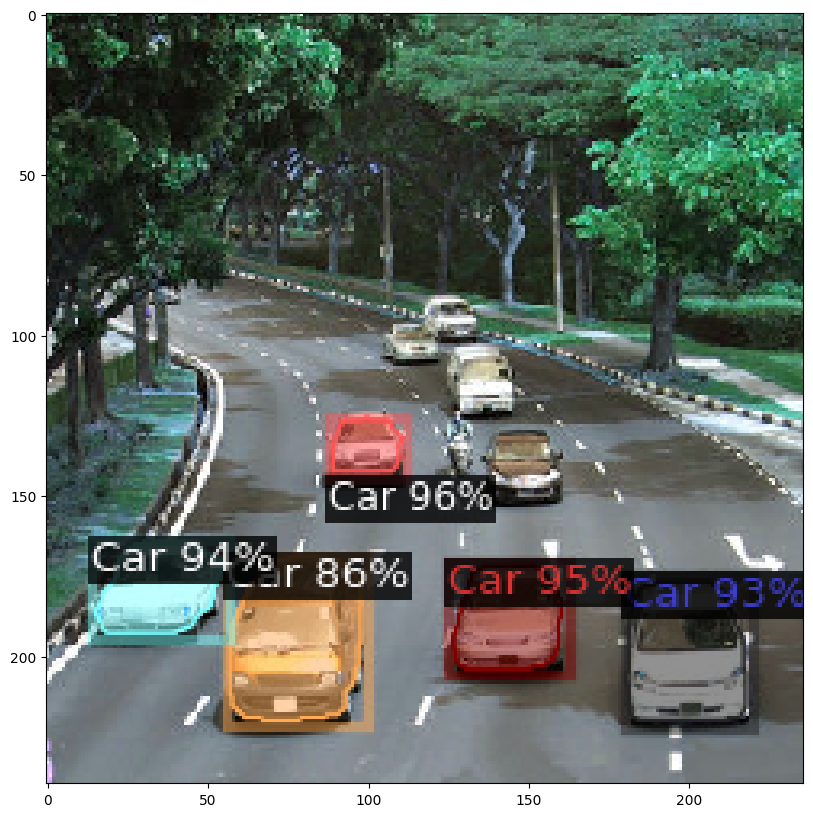

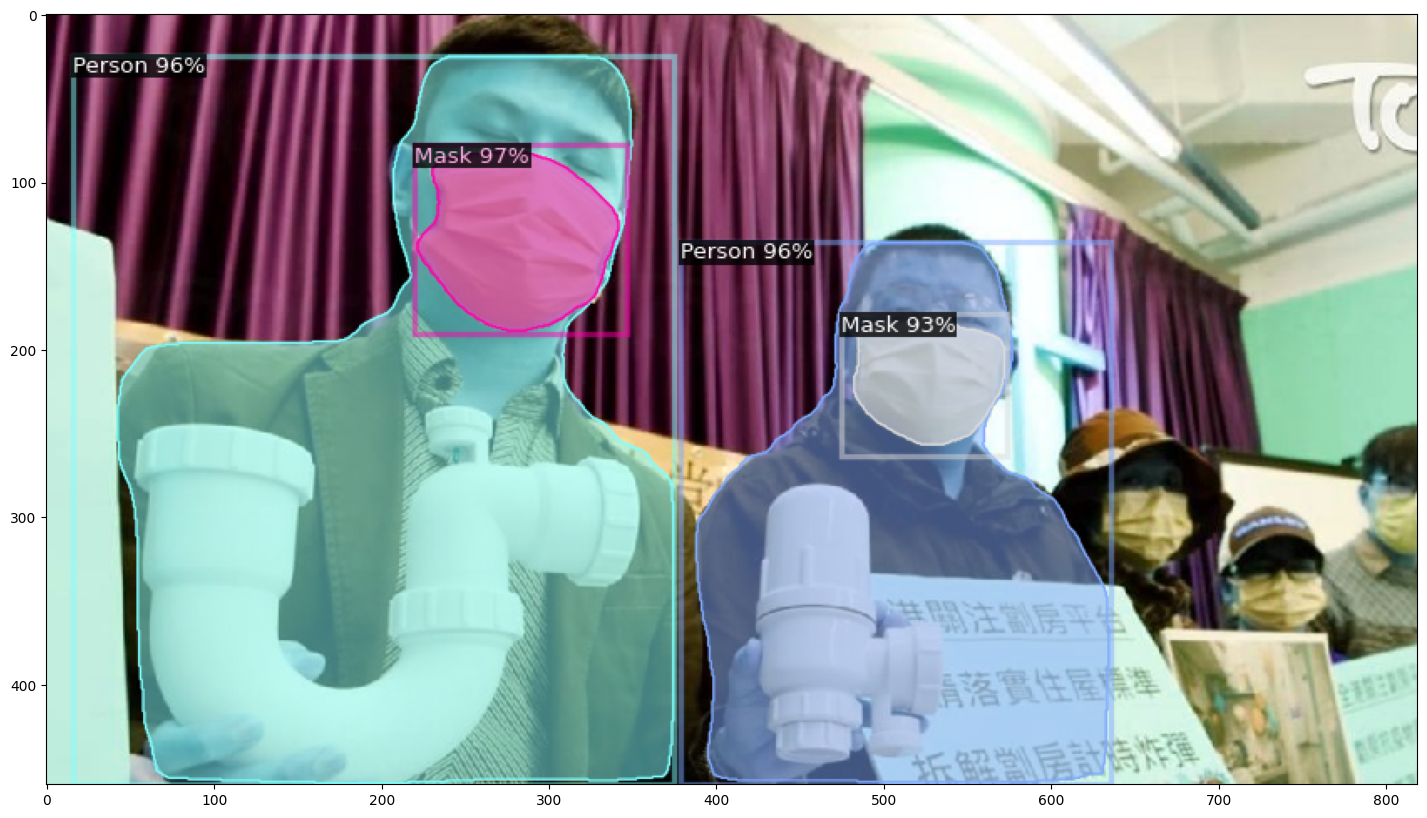

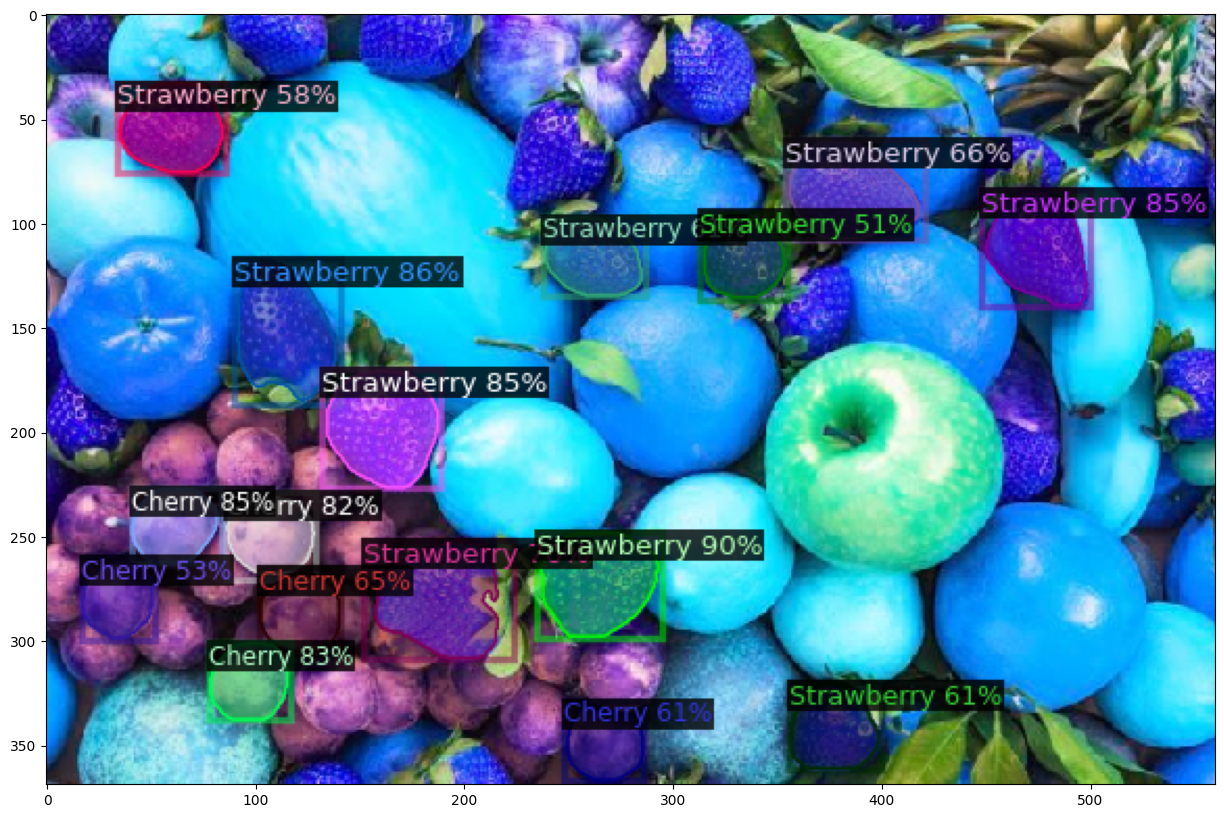

In [37]:
from detectron2.utils.visualizer import ColorMode
from matplotlib import pyplot as plt
for d in random.sample(dataset_dicts, 4):    
    im = cv2.imread(d["file_name"])
    outputs = predictor(im)
    v = Visualizer(im[:, :, ::-1],
                   metadata=sample_metadata, 
                   scale=0.8, 
                      # remove the colors of unsegmented pixels
    )
    v = v.draw_instance_predictions(outputs["instances"].to("cpu"))
    plt.figure(figsize=(20,10))
    plt.imshow(v.get_image()[:, :, ::-1])

# Evaluation

In [38]:
from detectron2.evaluation import COCOEvaluator, inference_on_dataset
from detectron2.data import build_detection_test_loader
evaluator = COCOEvaluator("sample", output_dir= "./output")
val_loader = build_detection_test_loader(cfg, "sample")
print(inference_on_dataset(predictor.model, val_loader, evaluator))

WARNING [10/22 17:06:15 d2.data.datasets.coco]: 
Category ids in annotations are not in [1, #categories]! We'll apply a mapping for you.

[10/22 17:06:15 d2.data.datasets.coco]: Loaded 51 images in COCO format from ./data/trainval.json
[10/22 17:06:15 d2.data.dataset_mapper]: [DatasetMapper] Augmentations used in inference: [ResizeShortestEdge(short_edge_length=(800, 800), max_size=1333, sample_style='choice')]
[10/22 17:06:15 d2.data.common]: Serializing the dataset using: <class 'detectron2.data.common._TorchSerializedList'>
[10/22 17:06:15 d2.data.common]: Serializing 51 elements to byte tensors and concatenating them all ...
[10/22 17:06:15 d2.data.common]: Serialized dataset takes 0.13 MiB
[10/22 17:06:15 d2.evaluation.evaluator]: Start inference on 51 batches
[10/22 17:06:44 d2.evaluation.evaluator]: Inference done 11/51. Dataloading: 0.0007 s/iter. Inference: 0.3157 s/iter. Eval: 0.0056 s/iter. Total: 0.3220 s/iter. ETA=0:00:12
[10/22 17:06:49 d2.evaluation.evaluator]: Inference

## Getting the custom config file

In [ ]:
pwd

'/content/drive/MyDrive/Classes/Detectron2'

In [39]:
f = open('config.yml', 'w')
f.write(cfg.dump())
f.close()

: 